In [52]:
from __future__ import print_function, division
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as mplib
import math
import thinkdsp
import thinkplot
from array import array
from itertools import chain, repeat
import copy
import pyaudio
import wave


%matplotlib inline

In [53]:
sig1 = thinkdsp.SinSignal(freq=500, amp = 1.5, offset = 0)
wav1 = sig1.make_wave(duration = 1,framerate=11025)

sig2 = thinkdsp.SinSignal(freq=1500, amp = 1.5, offset = 0)
wav2 = sig2.make_wave(duration = 1,framerate=11025)


In [54]:
def generate_tonal_sig(bits,symbol_len):
    transmit = thinkdsp.SinSignal(freq = 5000, amp = 1.5,offset=0)
    audio = transmit.make_wave(duration = symbol_len)
    for bit in bits:
        if bit == 0:
            sig = thinkdsp.SinSignal(freq=2300, amp = 1.5, offset = 0)
        if bit == 1:
            sig = thinkdsp.SinSignal(freq=3400, amp = 1.5, offset = 0)
        new_wav = sig.make_wave(duration = symbol_len)
        audio = audio | new_wav
    return audio
import bitarray
np.random.seed(1000)
bytes = np.random.bytes(8)
b = bitarray.bitarray()
b.frombytes(bytes)
print(b)
trans = generate_tonal_sig(b,.05)
trans.make_audio()
wfile = thinkdsp.WavFileWriter('longrandomseed1000.wav')
wfile.write(trans)
wfile.close()

bitarray('1011001110100101010100011010011101010111000100101001110100110100')


499.86398259
499.86398259
509.861262242
499.86398259
499.86398259
499.86398259
491.866158868


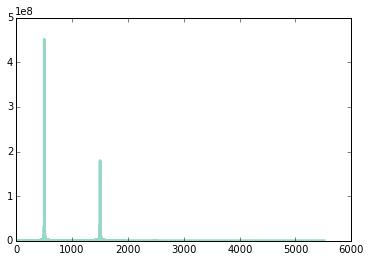

In [55]:
zeroHighCutoff = 510

zeroLowCuttoff = 490

wave = thinkdsp.read_wave('receivedfile.wav')

spectrum = wave.make_spectrum()

wave.make_audio()

windowSize = 0.5

results = []

for i in range(0, int(round(wave.duration / windowSize))):
    segment = wave.segment(i * windowSize, windowSize)
    segmentSpectrum = segment.make_spectrum()
    segmentSpectrum.low_pass(510)
    segmentSpectrum.high_pass(490)
    firstMaxFrequencyValue = segmentSpectrum.fs[np.argmax(segmentSpectrum.amps)]
    amplitude = max(segmentSpectrum.amps) / 2000
    
    print(firstMaxFrequencyValue)
    if amplitude > 1:
        results.append(0)
    else:
        results.append(1)

spectrum.plot()


In [56]:
np.random.seed(1000)

import bitarray
bytes = np.random.bytes(8)
b = bitarray.bitarray()
b.frombytes(bytes)

print(b)

stri = ":".join("{:02x}".format(ord(c)) for c in bytes)
#print(stri)

def detect_one_or_zero(segment, qfactor=.99, lowfreq=500, highfreq=1500):
    if len(segment.ys) < 3:
        print("too short")
        return
    segment2 = segment
    x = segment2.ys
    y = [ 0 for i in xrange(len(segment2.ys))]
    q = qfactor
    wo = (lowfreq * np.pi * 2) / segment2.framerate

    y[0] = x[0] + 2 * q - 2

    y[1] = x[1] + 2 * q * np.cos(wo) * y[0] - 2 * np.cos(wo) * x[0]

    for i in range(2, len(segment2.ys)):
        y[i] = x[i] + 2*q*np.cos(wo) * y[i-1] - q*q*y[i - 2] - 2 * np.cos(wo) * x[i-1] + x[i - 2]
    lowwave = thinkdsp.Wave(y, segment2.framerate)
    
    wo = (highfreq * np.pi * 2) / segment2.framerate
    
    y = [ 0 for i in xrange(len(segment2.ys))]
    
    y[0] = x[0] + 2 * q - 2

    y[1] = x[1] + 2 * q * np.cos(wo) * y[0] - 2 * np.cos(wo) * x[0]

    for i in range(2, len(segment2.ys)):
        y[i] = x[i] + 2*q*np.cos(wo) * y[i-1] - q*q*y[i - 2] - 2 * np.cos(wo) * x[i-1] + x[i - 2]
    highwave = thinkdsp.Wave(y, segment2.framerate)
    
    lowAverage = np.average(np.absolute(lowwave.ys))
    highAverage = np.average(np.absolute(highwave.ys))
    if lowAverage > highAverage and lowAverage > 1000: #tweak constant
        return "1"
    elif highAverage > lowAverage and highAverage > 1000: #tweak me
        return "0"
def find_start_and_end(xf, threshold = 2000): 
    import numpy as np    
    start_idx = -1
 
    for k in range(0, len(xf)):
        if(np.abs(xf[k])) > threshold:
            start_idx = k
            break

    if(start_idx  < 0):
        print("Unable to detect start of transmission")
        return -1
    
    end_idx = -1
    
    for k in range(0, len(xf)):
        if(np.abs(xf[len(xf)-k-1])) > threshold:
            end_idx = len(xf)-k-1
            break

    if(end_idx < 0):
        print("Unable to detect end of transmission")
        return -1

    return start_idx, end_idx

def process_wav(filename, symbolLength=.5):
    wave = thinkdsp.read_wave(filename)
    (start, end) = find_start_and_end(wave.ys)
    subwave = thinkdsp.Wave(wave.ys[start:end], wave.framerate)
    for i in range(0, int(round(wave.duration / windowSize))):
        print(detect_one_or_zero(wave.segment(i * windowSize, windowSize)))

bitarray('1011001110100101010100011010011101010111000100101001110100110100')


In [57]:
process_wav('receivedfile.wav')

0
0
1
0
0
0
1
